In [1]:
import numpy as np
import imu_core.imu_core_cpp as IMU

import meshcat
import pinocchio as pin
import time
from scipy.spatial.transform import Rotation
from bno_imu import BnoImu
import matplotlib.pyplot as plt

In [2]:
def add_frame(name, vis):
    xbox = meshcat.geometry.Box([0.1, 0.01, 0.01])
    vis["xbox_" + name].set_object(xbox, meshcat.geometry.MeshLambertMaterial(
                                    color=0xFF0000))
    ybox = meshcat.geometry.Box([0.01, 0.1, 0.01])
    vis["ybox_" + name].set_object(ybox, meshcat.geometry.MeshLambertMaterial(
                                    color=0x00FF00))
    zbox = meshcat.geometry.Box([0.01, 0.01, 0.1])
    vis["zbox_" + name].set_object(zbox, meshcat.geometry.MeshLambertMaterial(
                                    color=0x0000FF))

def update_frame(name, vis, R, offset = np.zeros(3)):
    X_TG = np.eye(4)
    X_TG[0,3] = 0.05
    Y_TG = np.eye(4)
    Y_TG[1,3] = 0.05
    Z_TG = np.eye(4)
    Z_TG[2,3] = 0.05

    offset_TG = np.eye(4)
    offset_TG[0:3,3] = offset


    T = np.eye(4)
    T[0:3,0:3] = R
    vis["xbox_" + name].set_transform( offset_TG @ T @ X_TG )
    vis["ybox_" + name].set_transform( offset_TG @ T @ Y_TG )
    vis["zbox_" + name].set_transform( offset_TG @ T @ Z_TG )

In [3]:
vis = meshcat.Visualizer()
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [4]:
micro_imu1 = IMU.Imu3DM_GX3_45("/dev/ttyACM5", True)
micro_imu1.initialize()
add_frame("1", vis)
micro_imu2 = IMU.Imu3DM_GX3_45("/dev/ttyACM6", True)
micro_imu2.initialize()
add_frame("2", vis)

rooh_imu1 = BnoImu("/dev/ttyACM0")
add_frame("3", vis)
rooh_imu2 = BnoImu("/dev/ttyACM1")
add_frame("4", vis)

UsbStream::read_device: Failed to read port /dev/ttyACM5. Requested 14 bytes and received 10 bytes: [ 75 65 0D 04 04 F1 03 00 E3 B6 ]
Warning this thread is not going to be real time.
UsbStream::read_device: Failed to read port /dev/ttyACM6. Requested 14 bytes and received 10 bytes: [ 75 65 0D 04 04 F1 03 00 E3 B6 ]
Warning this thread is not going to be real time.
UsbStream::read_device: Failed to read port /dev/ttyACM6. Requested 72 bytes and received 14 bytes: [ 75 65 0C 08 04 F1 11 00 04 F1 11 00 FA B5 ]


In [5]:
data_iRb1 = []
data_iRb2 = []
data_iRbr1 = []
data_iRbr2 = []

while True:
    iRb1 = (micro_imu1.get_rotation_matrix()).copy().T
    data_iRb1.append(iRb1)
    update_frame("1", vis, iRb1, np.array([0.2, 0, 0]))
    iRb2 = (micro_imu2.get_rotation_matrix()).copy().T
    data_iRb2.append(iRb2)
    update_frame("2", vis, iRb2, np.array([0.2, 0, 0]))

    time.sleep(0.01)
    try:
        iRbr1 = Rotation.from_quat(rooh_imu1.read()["q"]).as_matrix()
        data_iRbr1.append(iRbr1)
        update_frame("3", vis, iRbr1)
        iRbr2 = Rotation.from_quat(rooh_imu2.read()["q"]).as_matrix()
        data_iRbr2.append(iRbr2)
        update_frame("4", vis, iRbr2)
    except:
        print("missed signal")

KeyboardInterrupt: 

In [24]:
rooh_vec = []
micro_vec = []
for i in range(0, len(data_iRbr2)):
    error = Rotation.from_matrix(data_iRb1[i].T @ data_iRb2[i]).as_rotvec()
    micro_vec.append(np.linalg.norm(error))
    error = Rotation.from_matrix(data_iRbr1[i].T @ data_iRbr2[i]).as_rotvec()
    rooh_vec.append(np.linalg.norm(error))

rooh_vec = np.array(rooh_vec) 
micro_vec = np.array(micro_vec)
# rooh_vec *= (180./np.pi)
# micro_vec *= (180./np.pi)

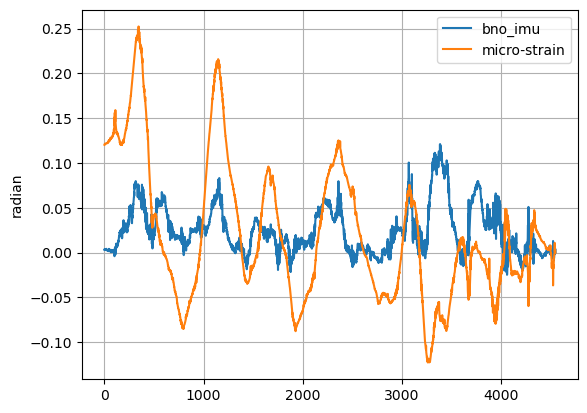

Exception in thread Thread-5 (update):
Traceback (most recent call last):
  File "/home/ameduri/miniconda3/envs/exoskeleton/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/ameduri/miniconda3/envs/exoskeleton/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ameduri/devel/exosketeon_firmware/python/bno_imu.py", line 18, in update
    data = self.serial.read_until(b'abc\n')
  File "/home/ameduri/miniconda3/envs/exoskeleton/lib/python3.10/site-packages/serial/serialutil.py", line 663, in read_until
    c = self.read(1)
  File "/home/ameduri/miniconda3/envs/exoskeleton/lib/python3.10/site-packages/serial/serialposix.py", line 595, in read
    raise SerialException(
serial.serialutil.SerialException: device reports readiness to read but returned no data (device disconnected or multiple access on port?)


In [25]:

plt.plot(rooh_vec - rooh_vec[-1], label = "bno_imu")
plt.plot(micro_vec - micro_vec[-1] , label = "micro-strain")
plt.ylabel("radian")
plt.legend()
plt.grid()
plt.savefig("bno_micro2.png")

In [22]:
bno_e = rooh_vec - rooh_vec[-1]
micro_e = micro_vec - micro_vec[-1]

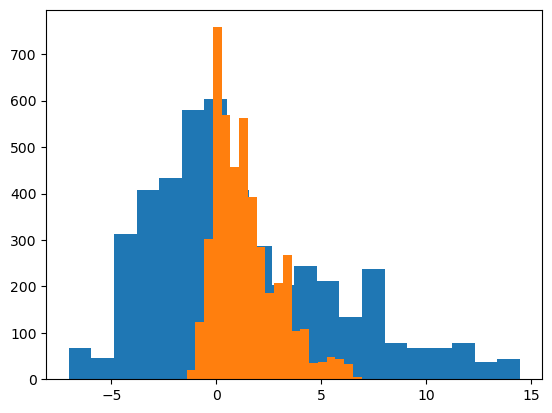

In [23]:
_ = plt.hist(micro_e, bins=20)
_ = plt.hist(bno_e, bins=20)
